# **Irene Dovichi** 
## Midterm 3 - Assignment 3
Train a neural network for sequences of your choice (LSTM, GRU, Convolutional, Clockwork RNN, ...) to predict the Benzene (C6H6 column) based on the sensor measurements timeseries (PT08.* columns) being fed in input to the recurrent model. Evaluate the predictive accuracy of the network on the task (using appropriately training/validation splits).  Confront the perfomance of this model, with another recurrent neural network trained to predict benzene one-step-ahead, i.e. given the current benzene measuement, predict its next value.
Show and compare performance of both settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

## Dataset Loading

In [2]:
df = pd.read_csv('air+quality/AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)

In [3]:
# Keep only Date, Time, C6H6, and PT08.* columns
df = df[['Date', 'Time', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
df.head()

,Date,Time,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,10/03/2004,18.00.00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0
1,10/03/2004,19.00.00,9.4,1292.0,955.0,1174.0,1559.0,972.0
2,10/03/2004,20.00.00,9.0,1402.0,939.0,1140.0,1555.0,1074.0
3,10/03/2004,21.00.00,9.2,1376.0,948.0,1092.0,1584.0,1203.0
4,10/03/2004,22.00.00,6.5,1272.0,836.0,1205.0,1490.0,1110.0


In [4]:
df.isna().sum()

Date             114
Time             114
C6H6(GT)         480
PT08.S1(CO)      480
PT08.S2(NMHC)    480
PT08.S3(NOx)     480
PT08.S4(NO2)     480
PT08.S5(O3)      480
dtype: int64

In [5]:
# Drop rows with nan values and reset index
df = df.dropna()
df = df.reset_index(drop=True)
df.isna().sum()

Date             0
Time             0
C6H6(GT)         0
PT08.S1(CO)      0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
dtype: int64

In [6]:
df.shape

(8991, 8)

In [7]:
# Combine Date and Time columns into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.drop(columns=['Date', 'Time'])
df.insert(0, 'DateTime', df.pop('DateTime'))

# We notice that df is ordered by DateTime since the min is the first row and the max is the last row
df['DateTime'].min(), df['DateTime'].max()

(Timestamp('2004-03-10 18:00:00'), Timestamp('2005-04-04 14:00:00'))

### Train/Test Split
Since the whole dataset covers more or less a year, we will inevitably have in the test set some months that weren't present in the train. Therefore, I decided to make a basic 80/20 split for the train/test and then for the train/val. The only precaution I had was not to mix the instances to maintain temporal sequentiality, and I made sure that the sets did not split one day.

In [8]:
# Calculate 80% of length of df
train_size = int(len(df) * 0.8)
train_size

7192

In [9]:
df.iloc[7189:7194]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
7189,2005-01-15 23:00:00,11.1,1231.0,1017.0,655.0,1207.0,1414.0
7190,2005-01-16 00:00:00,13.6,1289.0,1104.0,623.0,1257.0,1499.0
7191,2005-01-16 01:00:00,9.8,1166.0,970.0,705.0,1136.0,1306.0
7192,2005-01-16 02:00:00,7.6,1062.0,884.0,748.0,1062.0,1172.0
7193,2005-01-16 03:00:00,6.0,1028.0,813.0,794.0,1019.0,1076.0


We can notice that choosing instance 7189 as the last for the train will give approximately the 80% of the data as train data, and we avoid to stop in the middle of measurements for a specific day

In [10]:
train_start_date = df['DateTime'].iloc[0]
train_end_date = df['DateTime'].iloc[7189]

test_start_date = df['DateTime'].iloc[7190]
test_end_date = df['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
test = df[(df['DateTime'] >= test_start_date) & (df['DateTime'] <= test_end_date)]

In [11]:
# calculate 80% of length of train
train_size = int(len(train) * 0.8)
train_size

5752

In [12]:
train.iloc[5759:5764]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
5759,2004-11-11 21:00:00,16.8,1207.0,1203.0,625.0,1570.0,1251.0
5760,2004-11-11 22:00:00,4.8,904.0,754.0,930.0,1172.0,805.0
5761,2004-11-11 23:00:00,4.0,900.0,711.0,975.0,1153.0,736.0
5762,2004-11-12 00:00:00,4.5,932.0,740.0,926.0,1180.0,774.0
5763,2004-11-12 01:00:00,5.4,968.0,785.0,872.0,1209.0,826.0


In [13]:
train_start_date = train['DateTime'].iloc[0]
train_end_date = train['DateTime'].iloc[5761]

val_start_date = train['DateTime'].iloc[5762]
val_end_date = train['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
val = df[(df['DateTime'] >= val_start_date) & (df['DateTime'] <= val_end_date)]

In [14]:
# just a check that we have the correct number of instances
print(f'Wanted instances for train set: {int(len(df) * 0.8 * 0.8)} --> Actual instances: {len(train)}\n'
      f'Wanted instances for val set: {int(len(df) * 0.8 * 0.2)} --> Actual instances: {len(val)}\n'
      f'Wanted instances for test set: {int(len(df) * 0.2)} --> Actual instances: {len(test)}')

Wanted instances for train set: 5754 --> Actual instances: 5762
Wanted instances for val set: 1438 --> Actual instances: 1428
Wanted instances for test set: 1798 --> Actual instances: 1801


## Sensors Based Model

In [15]:
X_train = train[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_train = train['C6H6(GT)']

X_val = val[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_val = val['C6H6(GT)']

X_test = test[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_test = test['C6H6(GT)']

In [16]:
#TODO: see if NOT having the precaution of keeping a day into a set affects the performances

### Scaling
Concerning the scaling, I decided to use MinMaxScaler() in order to keep the features in a range of [0,1] but keeping their distributions.

In [17]:
# Scale X values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Scale y values
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [18]:
# TODO: ha senso scalare anche le y?

### Reshaping
I am going to use a LSTM layer first, which requires the data to be in the form: `[samples, time steps, features]`.

In [19]:
# TODO: spiegare cosa sono timesteps

In [20]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

## Model Selection
recap della prossima sezione

### Vanilla LSTM Model

In [21]:
# Vanilla LSTM model: 1 layer with 10 units
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  # Input layer
model.add(LSTM(10, activation='relu', return_sequences=True))  
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 10)          │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - loss: 0.0199 - val_loss: 0.0041
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.0024 - val_loss: 0.0033
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 0.0020 - val_loss: 0.0029
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 9.1967e-04 - val_loss: 0.0013
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 7.9389e-04 - val_loss: 0.0011
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 6.7782e-04 - val_loss: 9.8101e-04
Epo

Test Loss: 4.753737084683962e-05



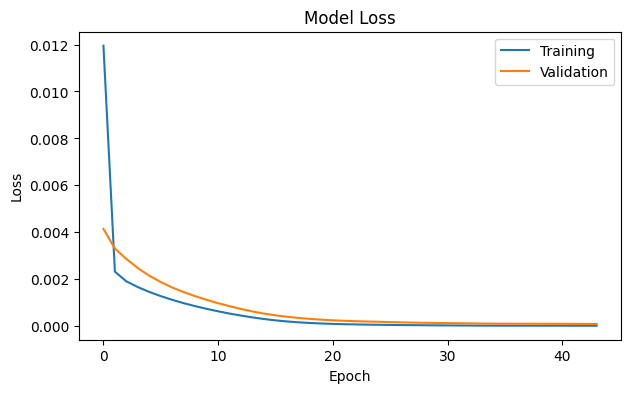

In [23]:
# Print test loss and accuracy
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(7, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [24]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [25]:
y_test.shape, y_pred.shape

((1801,), (1801, 1))

In [26]:
y_test = y_test.values.reshape(-1, 1)
y_test.shape

(1801, 1)

In [27]:
# compute mse between y_test and y_pred 
mse = mean_squared_error(y_test, y_pred)
print(f'MSE between y_test and y_pred: {mse}')

MSE between y_test and y_pred: 0.12755419786538497


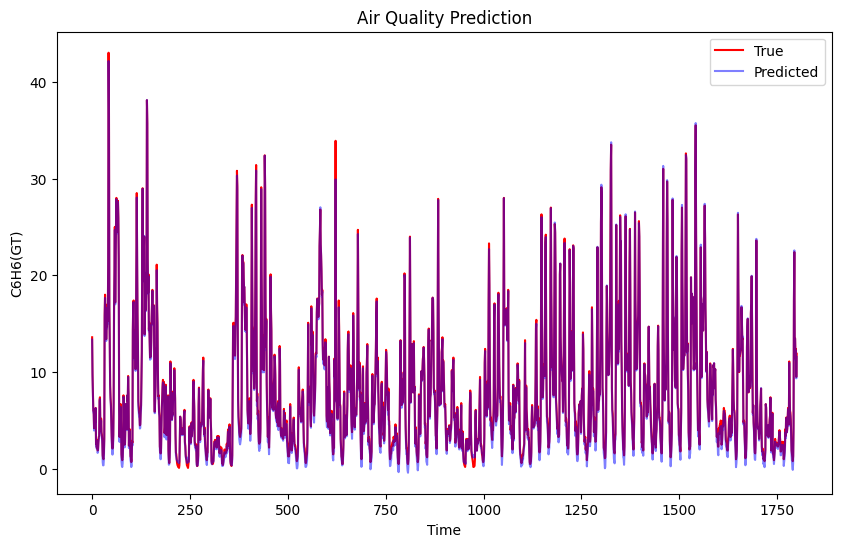

In [28]:
# plot y_test and y_pred
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='True')
plt.plot(y_pred, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

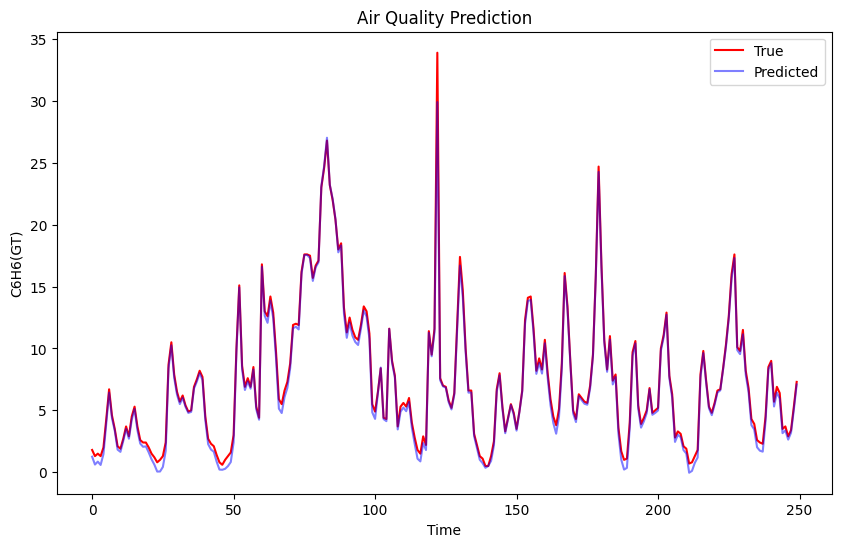

In [29]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test[500:750], color='red', label='True')
plt.plot(y_pred[500:750], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

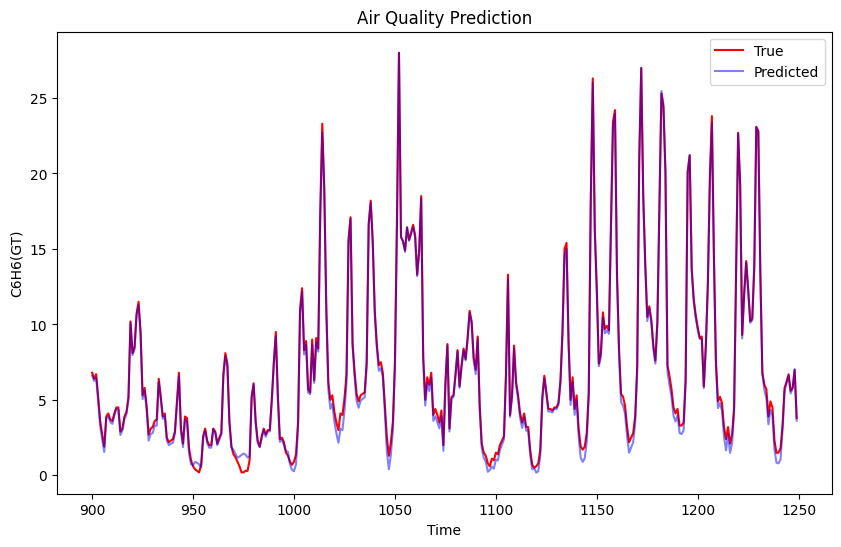

In [30]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test[900:1250], color='red', label='True')
plt.plot(y_pred[900:1250], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xticks(range(0, 1250-900+1, 50), range(900, 1251, 50))
plt.xlabel('Time')
plt.legend()
plt.show()

### Stacked LSTM Model
Let's try with a stacked LSTM model

In [31]:
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  # Input layer
model.add(LSTM(32, activation='relu', return_sequences=True))  
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 32)          │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,217 (51.63 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0323 - val_loss: 0.0031
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 9.7675e-04 - val_loss: 0.0011
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 8.4768e-04 - val_loss: 0.0010
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 7.1931e-04 - val_loss: 8.9641e-04
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 5.9176e-04 - val_loss: 7.6853e-04
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 4.7292e-04 - val_loss: 6.4219e-04
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 3.6354e-04 - val_loss: 5.3416e-04
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 2.6746e

Test Loss: 3.477969949017279e-05



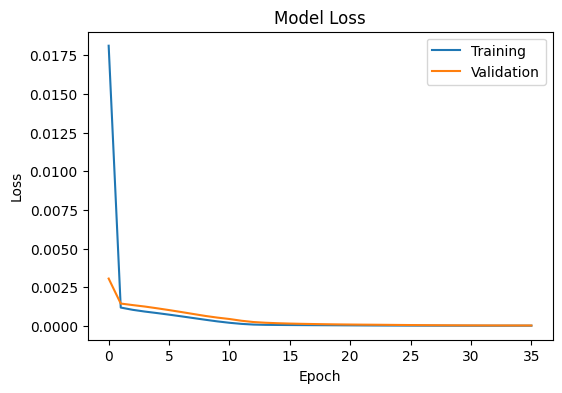

In [33]:
# Print test loss and accuracy
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [34]:
# Predict y values
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [35]:
mse = mean_squared_error(y_test, y_pred)
print(f'MSE between y_test and y_pred: {mse}')

MSE between y_test and y_pred: 0.09332225433930652


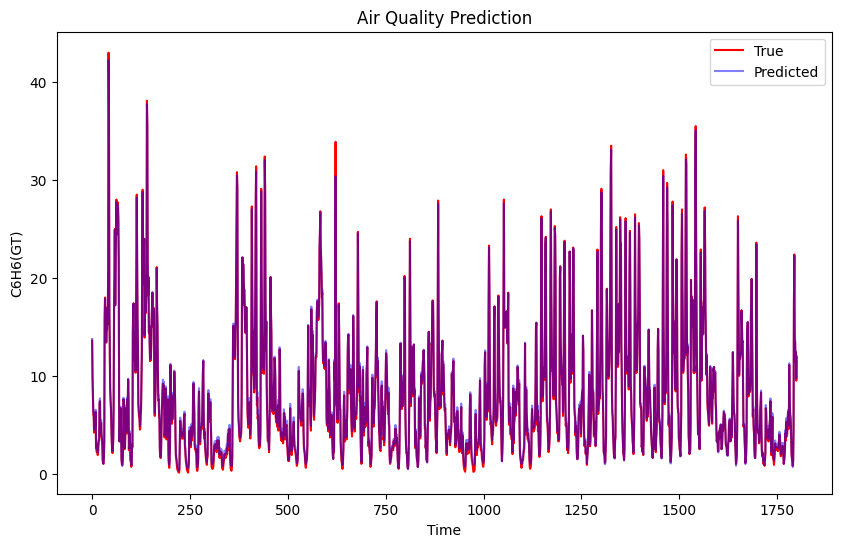

In [36]:
# plot y_test and y_pred
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='True')
plt.plot(y_pred, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

We can notice that the the pick between times 100-150 is now predicted pretty well, better with respect to the previous (vanilla) model!

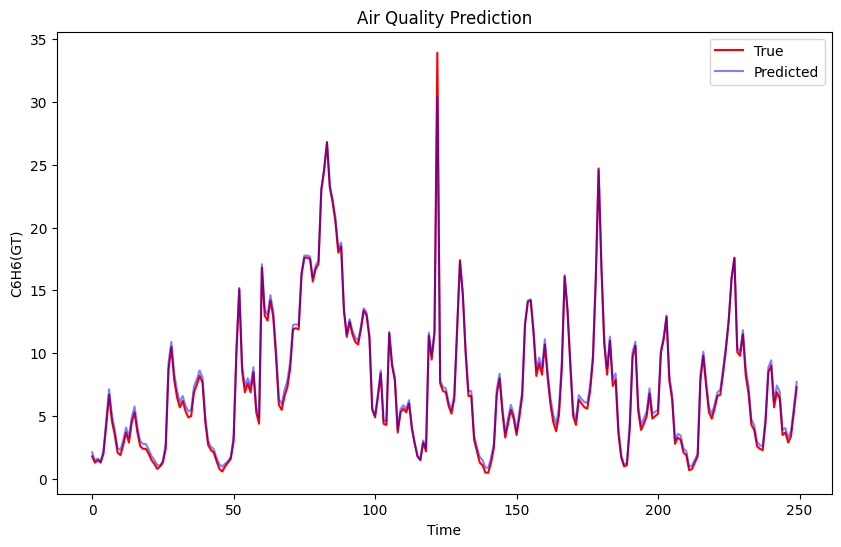

In [37]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test[500:750], color='red', label='True')
plt.plot(y_pred[500:750], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

Moreover, the predictions are better also between times 1250-1750. In the vanilla model we could notice that the predictions were lower than the true values

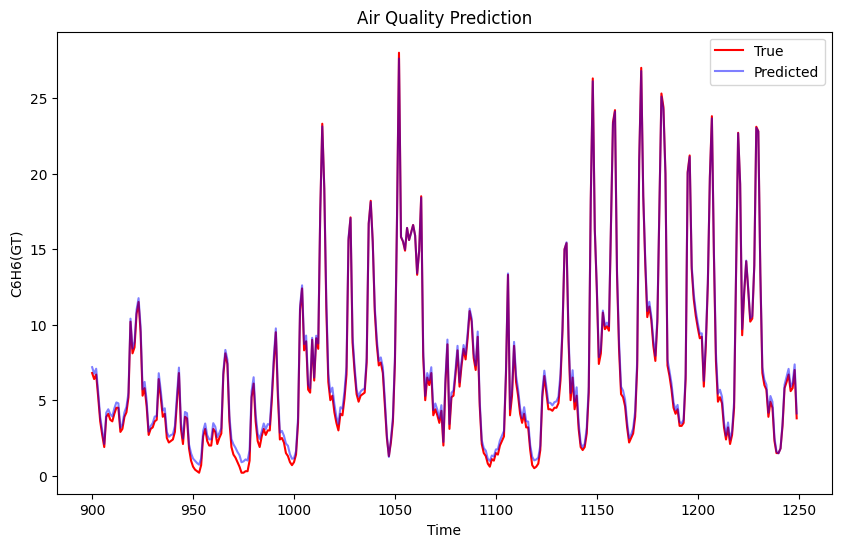

In [38]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test[900:1250], color='red', label='True')
plt.plot(y_pred[900:1250], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xticks(range(0, 1250-900+1, 50), range(900, 1251, 50))
plt.xlabel('Time')
plt.legend()
plt.show()

# !!! Another model: Convolutional or GRU
confront with lstm

## One-step ahead Model

In [39]:
# We have already split the data into train, val, and test sets paying attention to the order of the instances
train.shape, val.shape, test.shape

((5762, 7), (1428, 7), (1801, 7))

In [40]:
# Keep only the Benzene column
train_B = train[['C6H6(GT)']]
val_B = val[['C6H6(GT)']]
test_B = test[['C6H6(GT)']]

type(train_B), type(val_B), type(test_B)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [41]:
# The target of each Benzene prediction is the next Benzene value
def prepare_data(data):
    X = data[:-1]
    y = data[1:]
    return X, y

In [42]:
# Let the DataFrames become numpy arrays
train_B = train_B.to_numpy()
val_B = val_B.to_numpy()
test_B = test_B.to_numpy()

# Let's prepare the data
X_train_seq, y_train_seq = prepare_data(train_B)
X_val_seq, y_val_seq = prepare_data(val_B)
X_test_seq, y_test_seq = prepare_data(test_B)

In [43]:
X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape

((5761, 1), (5761, 1), (1427, 1), (1427, 1), (1800, 1), (1800, 1))

### Scaling

In [57]:
# print min and max values of X_train_seq and y_train_seq
X_train_seq.min(), X_train_seq.max(), y_train_seq.min(), y_train_seq.max()

(0.3, 52.1, 0.3, 52.1)

In [44]:
# Scale X values
scaler = MinMaxScaler()
X_train_seq_scaled = scaler.fit_transform(X_train_seq)
X_val_seq_scaled = scaler.transform(X_val_seq)
X_test_seq_scaled = scaler.transform(X_test_seq)

# Scale y values with the same scaler used for X values
y_train_seq_scaled = scaler.transform(y_train_seq)
y_val_seq_scaled = scaler.transform(y_val_seq)
y_test_seq_scaled = scaler.transform(y_test_seq)

### Reshaping

In [45]:
X_train_seq_scaled = X_train_seq_scaled.reshape((X_train_seq_scaled.shape[0], 1, X_train_seq_scaled.shape[1]))
X_val_seq_scaled = X_val_seq_scaled.reshape((X_val_seq_scaled.shape[0], 1, X_val_seq_scaled.shape[1]))
X_test_seq_scaled = X_test_seq_scaled.reshape((X_test_seq_scaled.shape[0], 1, X_test_seq_scaled.shape[1]))

In [46]:
print(X_train_seq_scaled.shape, y_train_seq_scaled.shape)
print(X_val_seq_scaled.shape, y_val_seq_scaled.shape)
print(X_test_seq_scaled.shape, y_test_seq_scaled.shape)

(5761, 1, 1) (5761, 1)
(1427, 1, 1) (1427, 1)
(1800, 1, 1) (1800, 1)


## Model Selection

### Vanilla LSTM Model

In [47]:
# Vanilla LSTM model: 1 layer with 10 units
model = Sequential()
model.add(Input(shape=(X_train_seq_scaled.shape[1], X_train_seq_scaled.shape[2])))  # Input layer
model.add(LSTM(10, activation='relu', return_sequences=True))  
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 1)           │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_seq_scaled, y_train_seq_scaled, epochs=100, batch_size=32, validation_data=(X_val_seq_scaled, y_val_seq_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - loss: 0.0295 - val_loss: 0.0150
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.0115 - val_loss: 0.0120
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.0095 - val_loss: 0.0094
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.0071 - val_loss: 0.0068
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.0068 - val_loss: 0.0065
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.0067 - val_loss: 0.0064
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.0067 - val_loss: 0.0064
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.0067 - val_loss: 0.0063
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.0066 - val_loss: 0.0063
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.0066 - val_loss: 0.0062
Epoch 12/100
181/18

Test Loss: 0.005177724175155163



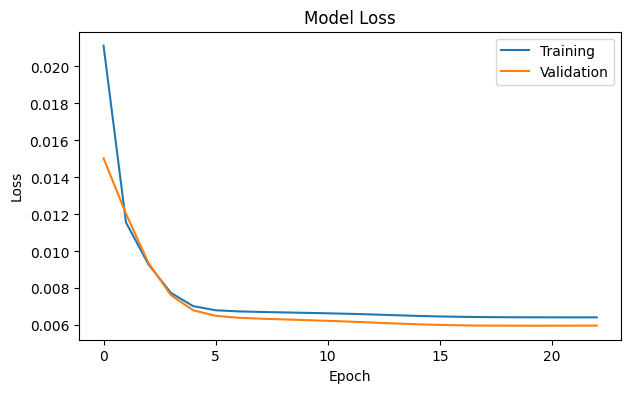

In [49]:
# Print test loss and accuracy
loss = model.evaluate(X_test_seq_scaled, y_test_seq_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(7, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [50]:
y_pred_seq_scaled = model.predict(X_test_seq_scaled)
y_pred_seq_scaled = y_pred_seq_scaled.reshape(-1, 1)
y_pred_seq = scaler.inverse_transform(y_pred_seq_scaled) 

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [51]:
y_test_seq.shape, y_pred_seq.shape

((1800, 1), (1800, 1))

In [52]:
mse = mean_squared_error(y_test_seq, y_pred_seq)
print(f'MSE between y_test_seq and y_pred_seq: {mse}')

MSE between y_test_seq and y_pred_seq: 13.89307489149009


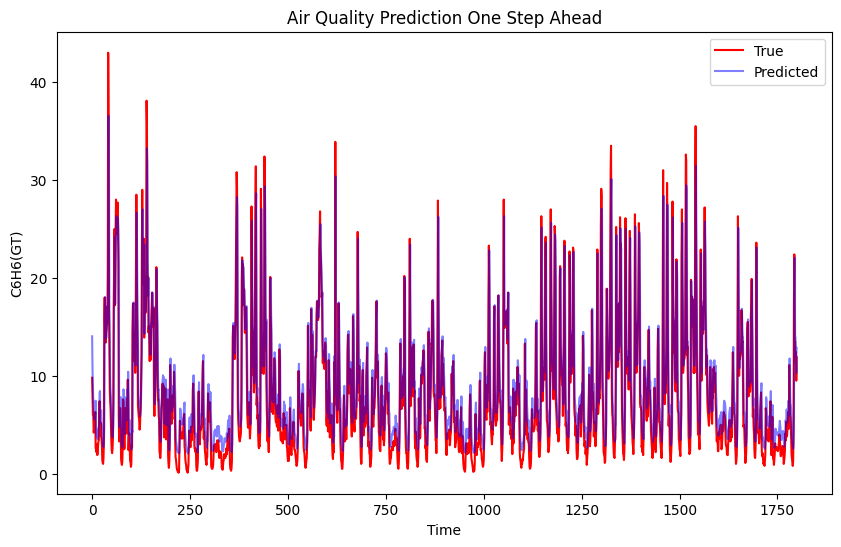

In [53]:
# plot y_test_seq and y_pred_seq
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, color='red', label='True')
plt.plot(y_pred_seq, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

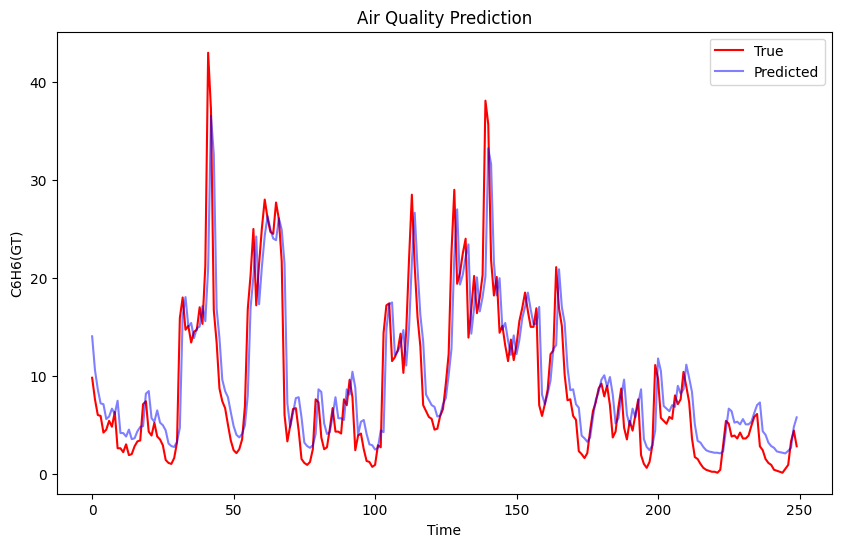

In [54]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq[:250], color='red', label='True')
plt.plot(y_pred_seq[:250], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

### Stacked LSTM Model

In [59]:
model = Sequential()
model.add(Input(shape=(X_train_seq_scaled.shape[1], X_train_seq_scaled.shape[2])))  # Input layer
model.add(LSTM(32, activation='relu', return_sequences=True))  
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Phase

In [60]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train_seq_scaled, y_train_seq_scaled, epochs=100, batch_size=32, validation_data=(X_val_seq_scaled, y_val_seq_scaled), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0316 - val_loss: 0.0191
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.0122 - val_loss: 0.0095
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 0.0078 - val_loss: 0.0073
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.0071 - val_loss: 0.0070
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.0069 - val_loss: 0.0066
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.0067 - val_loss: 0.0062
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.0065 - val_loss: 0.0060
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.0064 - val_loss: 0.0060
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 12/100
181/181 

Test Loss: 0.00501972297206521



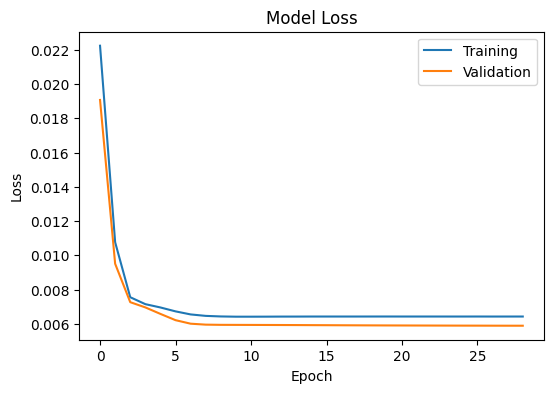

In [61]:
# Print test loss and accuracy
loss = model.evaluate(X_test_seq_scaled, y_test_seq_scaled, verbose=0)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [62]:
# Predict y values
y_pred_seq_scaled = model.predict(X_test_seq_scaled)
y_pred_seq_scaled = y_pred_seq_scaled.reshape(-1, 1)
y_pred_seq = scaler.inverse_transform(y_pred_seq_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [63]:
mse = mean_squared_error(y_test_seq, y_pred_seq)
print(f'MSE between y_test_seq and y_pred_seq: {mse}')

MSE between y_test_seq and y_pred_seq: 13.469123378503747


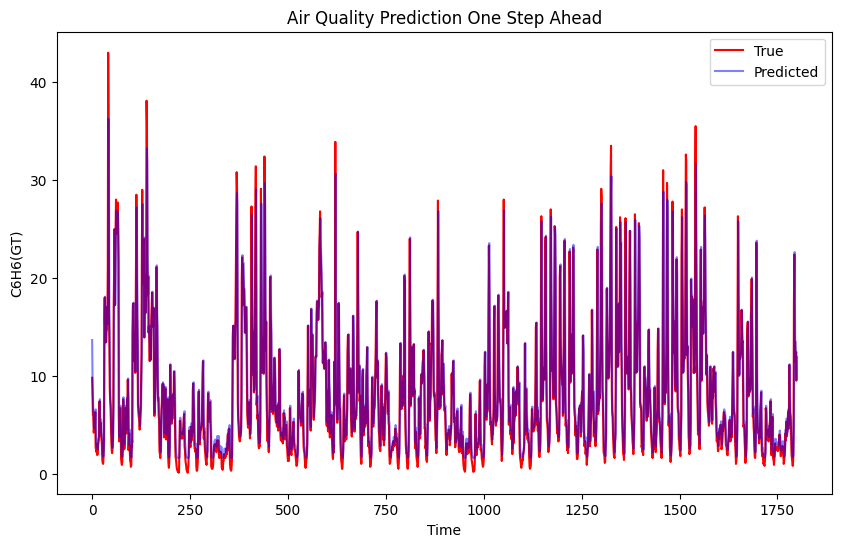

In [64]:
# plot y_test_seq and y_pred_seq
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, color='red', label='True')
plt.plot(y_pred_seq, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

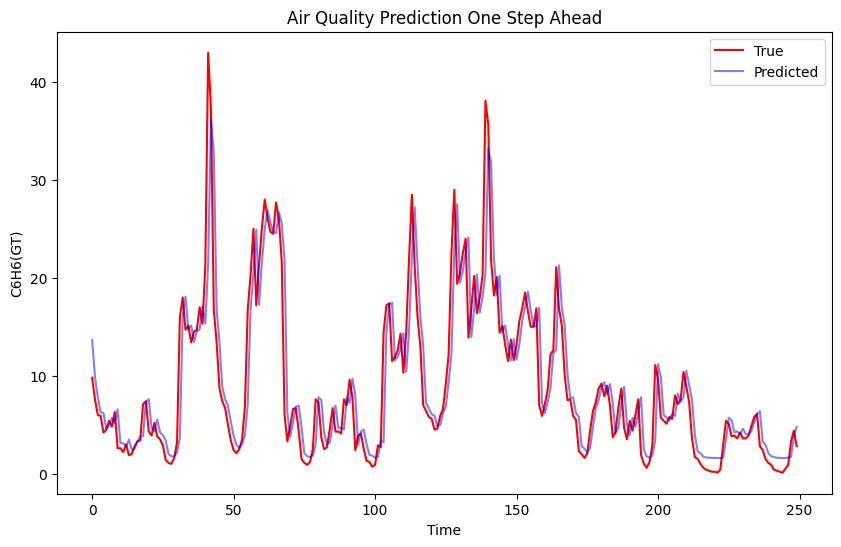

In [65]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq[:250], color='red', label='True')
plt.plot(y_pred_seq[:250], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction One Step Ahead')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

## Personal Considerations

In [67]:
# see the correlation between the features of df and the target C6H6(GT)
df.corr()['C6H6(GT)']

DateTime        -0.064292
C6H6(GT)         1.000000
PT08.S1(CO)      0.883795
PT08.S2(NMHC)    0.981950
PT08.S3(NOx)    -0.735744
PT08.S4(NO2)     0.765731
PT08.S5(O3)      0.865689
Name: C6H6(GT), dtype: float64

In [56]:
# il dropout nel primo modello rendeva le performances peggiori: forse perchè il modello era troppo semplice e il dropout lo rendeva ancora più semplice